In [116]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install albumentations

In [117]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Explore data

In [118]:
import os

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
base_path = "/content/drive/MyDrive/datasets"

# Wave


In [123]:
import albumentations as A
import cv2
import os
import numpy as np

#ดั้งเดิม มี 36 รูป
BASE_PATH = "/content/drive/My Drive/datasets/wave/training"

# OUTPUT_PATH = "/content/drive/My Drive/datasets/wave_augmented_combined"
# สร้าง 20 รูปใหม่ ต่อ 1 รูปต้นฉบับ
ITERATIONS = 20

transform = A.Compose([
    # หมุนเล็กน้อย
    A.Rotate(limit=15, p=0.7),
    # พลิกซ้ายขวา
    A.HorizontalFlip(p=0.5),
    # ปรับแสง
    A.RandomBrightnessContrast(p=0.4, brightness_limit=0.1, contrast_limit=0.1)
])


# ฟังก์ชันวนลูปสร้างไฟล์
def create_augmented_files(src_dir, dest_dir, iterations):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    print(f"Processing folder: {src_dir}")

    for filename in os.listdir(src_dir):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(src_dir, filename)
            base_name = os.path.splitext(filename)[0]

            # 1. โหลดรูปด้วย OpenCV
            img = cv2.imread(img_path)
            # ตรวจสอบว่าโหลดรูปสำเร็จหรือไม่
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue

            # 2. บันทึกรูปต้นฉบับ
            cv2.imwrite(os.path.join(dest_dir, filename), img)

            # 3. สร้างไฟล์ใหม่ตามจำนวน iterations
            for i in range(iterations):
                # สั่งแปลงรูปตาม "สูตร" ที่เราสร้างไว้
                transformed = transform(image=img)
                augmented_image = transformed["image"]

                # สร้างชื่อไฟล์ใหม่
                new_filename = f"{base_name}_aug_combined_{i}.png"
                full_output_path = os.path.join(dest_dir, new_filename)

                # บันทึกไฟล์
                cv2.imwrite(full_output_path, augmented_image)



for subset in ["training"]:
    for label in ["healthy", "parkinson"]:
        src_dir = os.path.join(BASE_PATH, subset, label)
        dest_dir = os.path.join(OUTPUT_PATH, subset, label)

        # ตรวจสอบว่า src_dir มีอยู่จริง
        if not os.path.exists(src_dir):
            print(f"Warning: Source directory not found: {src_dir}. Skipping.")
            continue

        create_augmented_files(src_dir, dest_dir, ITERATIONS)

print(f"--- Combined Augmentation เสร็จสมบูรณ์! ---")
print(f"ข้อมูลใหม่ของคุณอยู่ที่: {OUTPUT_PATH}")

--- Combined Augmentation เสร็จสมบูรณ์! ---
ข้อมูลใหม่ของคุณอยู่ที่: /content/drive/My Drive/datasets/wave_augmented_combined


In [138]:

base_path = "/content/drive/My Drive/datasets/wave"
augment_path ="/content/drive/My Drive/datasets/wave_augmented_combined"
train_dir_w = os.path.join(augment_path, "training")
test_dir_w = os.path.join(base_path, "testing")

IMG_SIZE = (200, 200)
BATCH_SIZE = 16


train_dataset_w = tf.keras.utils.image_dataset_from_directory(
    train_dir_w,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',        # ให้ label เป็นตัวเลข (0, 1, 2...)
    validation_split=0.2,
    subset='training',
    seed=123  ,               # ใส่ seed เพื่อให้การสุ่มแบ่งข้อมูลเหมือนเดิมทุกครั้ง
    color_mode='grayscale'
)

validation_dataset_w = tf.keras.utils.image_dataset_from_directory(
    train_dir_w,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123 , # ใช้ seed เดียวกันเพื่อให้ข้อมูลไม่ปนกัน
    color_mode='grayscale'
)


test_dataset_w = tf.keras.utils.image_dataset_from_directory(
    test_dir_w,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    color_mode='grayscale',
    shuffle=False
)

class_names = train_dataset_w.class_names
print(f"โปรแกรมเจอ Labels (Classes) คือ: {class_names}")


print(f"'{class_names[0]}' ถูกกำหนดเป็น Label 0")
print(f"'{class_names[1]}' ถูกกำหนดเป็น Label 1")

Found 1512 files belonging to 2 classes.
Using 1210 files for training.
Found 1512 files belonging to 2 classes.
Using 302 files for validation.
Found 30 files belonging to 2 classes.
โปรแกรมเจอ Labels (Classes) คือ: ['healthy', 'parkinson']
'healthy' ถูกกำหนดเป็น Label 0
'parkinson' ถูกกำหนดเป็น Label 1


--- Preprocessing Pipeline (Online) เสร็จสมบูรณ์ ---
กำลังแสดงตัวอย่างรูปภาพที่ประมวลผลแล้ว...


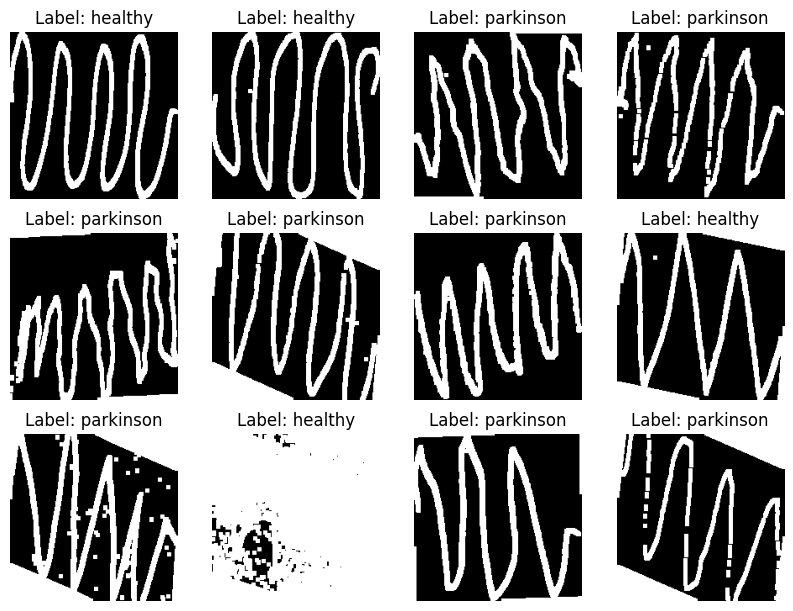

In [125]:

def preprocess_image(image, label,normalize=True):

    # 1. Invert และ Thresholding
    image_float = tf.cast(image, tf.float32)
    processed_image = tf.where(image_float < 190.0, 255.0, 0.0)

    # 2. Dilation (ขยายเส้น)
    kernel = tf.ones((5, 5, 1), dtype=tf.float32)
    dilated_image = tf.nn.dilation2d(
        input=processed_image,
        filters=kernel,
        strides=(1, 1, 1, 1),
        padding="SAME",
        dilations=(1, 1, 1, 1),
        data_format="NHWC"
    )
    # 3. Normalization
    if normalize:
      final_image = dilated_image / 255.0
    else:
      final_image = dilated_image

    return final_image, label

# --- 4. ใช้ .map() เพื่อ Preprocessing ข้อมูลทั้ง 3 ชุด ---

AUTOTUNE = tf.data.AUTOTUNE

train_dataset_w = train_dataset_w.map(preprocess_image, num_parallel_calls=AUTOTUNE)
validation_dataset_w = validation_dataset_w.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset_w = test_dataset_w.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# --- 5. เพิ่มประสิทธิภาพ (สำคัญมาก) ---

train_dataset_w = train_dataset_w.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset_w = validation_dataset_w.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_w = test_dataset_w.prefetch(buffer_size=AUTOTUNE)

print("--- Preprocessing Pipeline (Online) เสร็จสมบูรณ์ ---")


print("กำลังแสดงตัวอย่างรูปภาพที่ประมวลผลแล้ว...")

plt.figure(figsize=(10, 10))
# .take(1) คือการดึงข้อมูลมา 1 Batch
for images, labels in train_dataset_w.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

In [126]:
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 1)
NUM_CLASSES = len(class_names) # ควรจะได้ 2 (healthy, parkinson)
print(NUM_CLASSES)

2


In [137]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


model_w = models.Sequential([

    layers.Input(shape=INPUT_SHAPE),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_w.summary()

model_w.compile(
    optimizer= Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 32

history = model_w.fit(
    train_dataset_w,
    validation_data=validation_dataset_w,
    epochs=EPOCHS,
)

print("\n--- การเทรนเสร็จสมบูรณ์ ---")


print("\n--- กำลังประเมินผลด้วย Test Set ---")
test_loss, test_acc = model_w.evaluate(test_dataset_w)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 198, 198, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 198, 198, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 99, 99, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 99, 99, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 97, 97, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │    18,874,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,949,249 (72.29 MB)

 Trainable params: 18,949,121 (72.29 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.5753 - loss: 0.8964 - val_accuracy: 0.7318 - val_loss: 0.6813
Epoch 2/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6970 - loss: 0.5755 - val_accuracy: 0.7881 - val_loss: 0.6561
Epoch 3/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7133 - loss: 0.5221 - val_accuracy: 0.8212 - val_loss: 0.6380
Epoch 4/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7998 - loss: 0.4530 - val_accuracy: 0.8576 - val_loss: 0.5998
Epoch 5/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7924 - loss: 0.4068 - val_accuracy: 0.8576 - val_loss: 0.5523
Epoch 6/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8453 - loss: 0.3428 - val_accuracy: 0.8742 - val_loss: 0.4924
Epoch 7/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8648 - loss: 0.3369 - val_accuracy: 0.8907 - val_loss: 0.4422
Epoch 8/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8764 - loss: 0.3088 - val_accuracy: 0.9007 - 

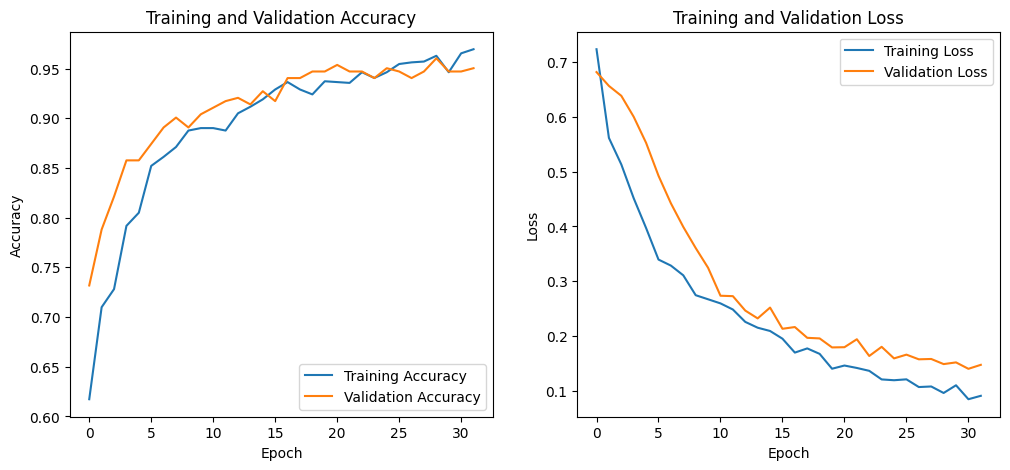

In [139]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# แสดงกราฟ
plt.show()